In [1]:
import pandas as pd 
import os
import time
import csv
import itertools
import collections
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import copy as cp
import numpy as np 
from numpy.fft import fft, ifft
from typing import Tuple

import scipy
from scipy import stats
from sklearn import preprocessing, svm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.neural_network import MLPClassifier

import tsfresh as tf
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.feature_extraction import ComprehensiveFCParameters

import keras
import tensorflow as tsf
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Input, BatchNormalization, Activation, Embedding, Add, LSTM, SimpleRNN
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint


plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [2]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.RdYlBu):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'], linewidth=8, c='black')
    plt.plot(history.history['val_accuracy'], linewidth=8, c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'], linewidth=8, c='black')
    plt.plot(history.history['val_loss'], linewidth=8, c='red')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

# Data Visualization & Preprocessing 

In [3]:
path = './mitbih_database/'
window_size = 180
maximum_counting = 10000
other_beats=[]

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# read files
filenames = next(os.walk(path))[2]

records = list()
annotations = list()
filenames.sort()

# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
        
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        
            # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    
                    X.append(beat)
                    y.append(arrhythmia_index)
            else:
                other_beats.append(arrhythmia_type)
                

# data shape
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

X_df = pd.DataFrame(X)
#converting uV to mV

print('This is what the df looks like, where 0-359 is the time in ms and row # is the sample number')
X_df.head()

This is what the df looks like, where 0-359 is the time in ms and row # is the sample number


,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,957,956,961,964,964,966,965,966,967,969,...,957,958,958,955,955,955,960,958,957,0
1,950,951,952,951,956,959,961,960,958,958,...,948,950,952,951,952,951,948,950,951,0
2,946,949,952,956,957,958,957,957,959,960,...,957,957,958,957,956,957,960,956,956,0
3,960,961,960,959,961,965,967,964,965,967,...,956,958,960,961,959,957,953,955,956,0
4,939,940,943,948,950,951,951,951,955,958,...,962,962,962,958,957,958,960,959,959,0


In [78]:
#Print out the labels that were in the data but not used by us / weren't in the five specified classes

others = pd.DataFrame({
    'Symbol' : np.unique(other_beats, return_counts=True)[0],
    'Count' : np.unique(other_beats, return_counts=True)[1] })

others.sort_values('Count', ascending=False)

,Symbol,Count
3,/,7028
2,+,1291
13,f,982
5,F,803
17,~,616
0,!,472
1,"""",437
14,j,229
15,x,193
11,a,150


## *** Note about the other beat labels present in data

https://archive.physionet.org/physiobank/annotations.shtml shows a key of all of the above symbols' meanings. The only category that has enough samples to include and still keep a large, evenly sampled data set is '/' or 'Paced Beat'. Many of the other symbols don't indicate a beat type but the start or end of a relevant event, i.e. '[' & ']' represent the beginning/end of ventricular flutter, or '+' indicates a rhythm change. 

Paced beats ('/') could be added to the below work as a sixth class, but for the sake of time in this course we will only consider the 5 original classes. 

Text(0, 0.5, 'Amplitude (mV)')

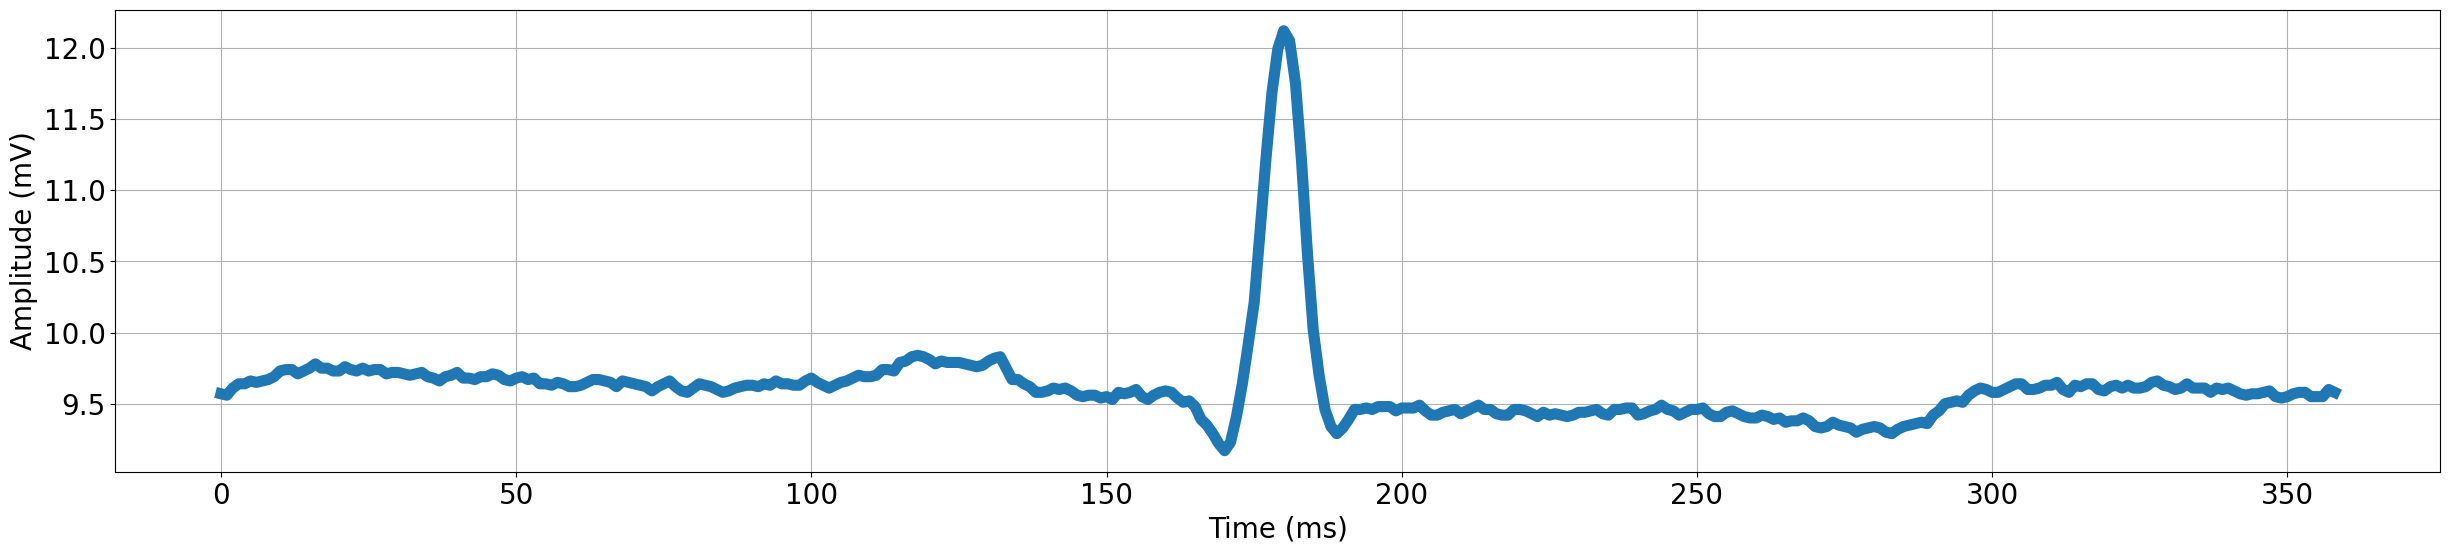

In [6]:
#print an example beat in mV
ex = X_df/100
ex.iloc[0,0:359].plot(linewidth=8)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')

0    75011
1     8071
2     7255
4     7129
3     2546
Name: 360, dtype: int64


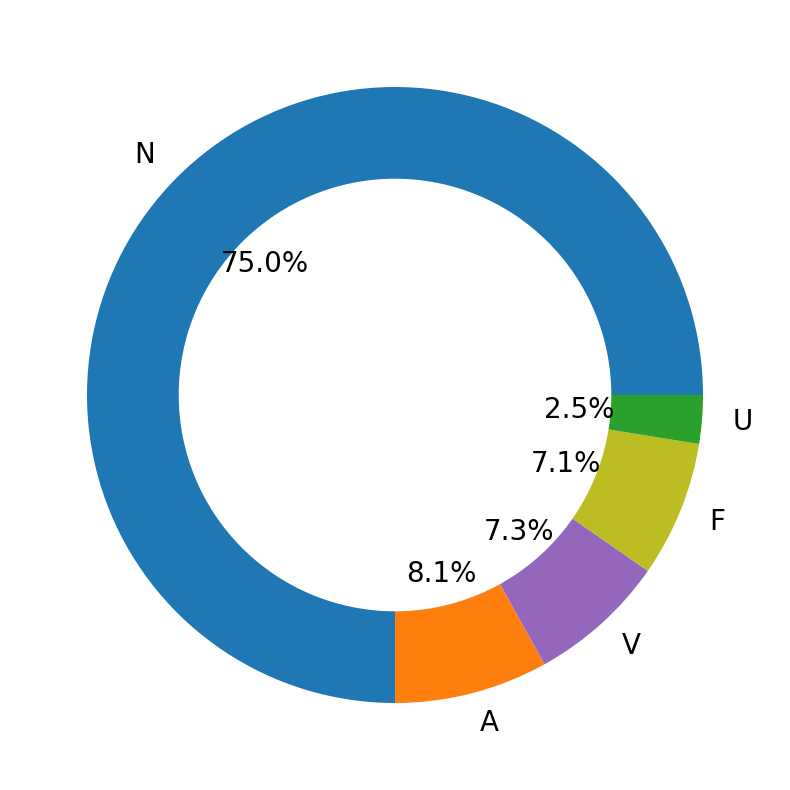

In [7]:
#data distribution before resampling
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [8]:
#resample the data so that there are equal amounts of each category
df_1=X_df[X_df[X_df.shape[1]-1]==1]
df_2=X_df[X_df[X_df.shape[1]-1]==2]
df_3=X_df[X_df[X_df.shape[1]-1]==3]
df_4=X_df[X_df[X_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_df[X_df[X_df.shape[1]-1]==0]).sample(n=6000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=6000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=6000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=6000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=6000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_df_resam=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0    6000
1    6000
2    6000
3    6000
4    6000
Name: 360, dtype: int64


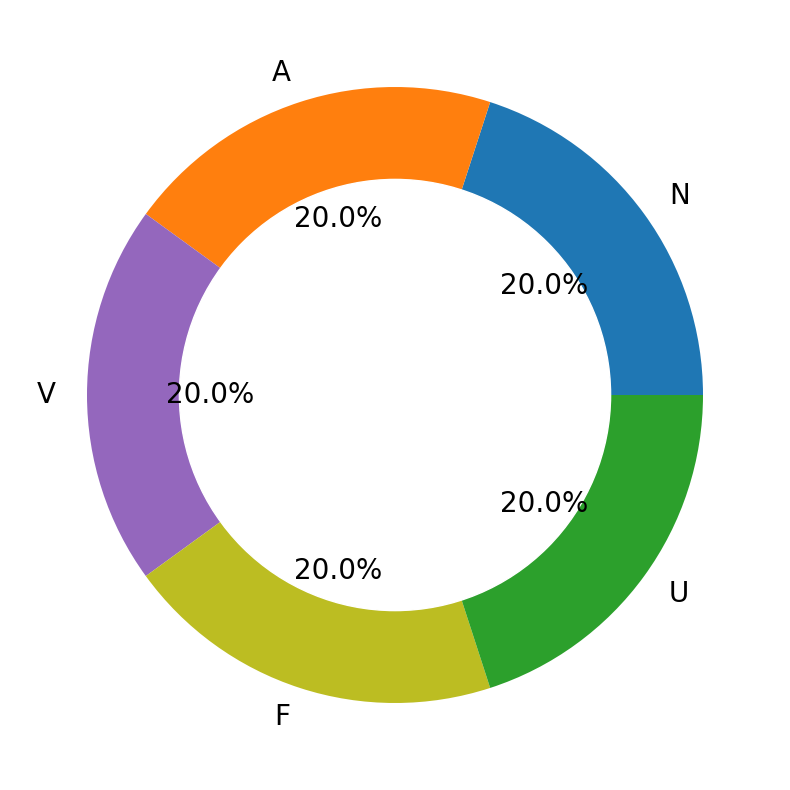

In [9]:
#show redistribution of data
per_class = X_df_resam[X_df_resam.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
category = X_df_resam[360]
X_df_resam.drop([360], axis=1, inplace=True)
#change units from uV to mV
X_df_resam = X_df_resam/100

(4.0, 15.0)

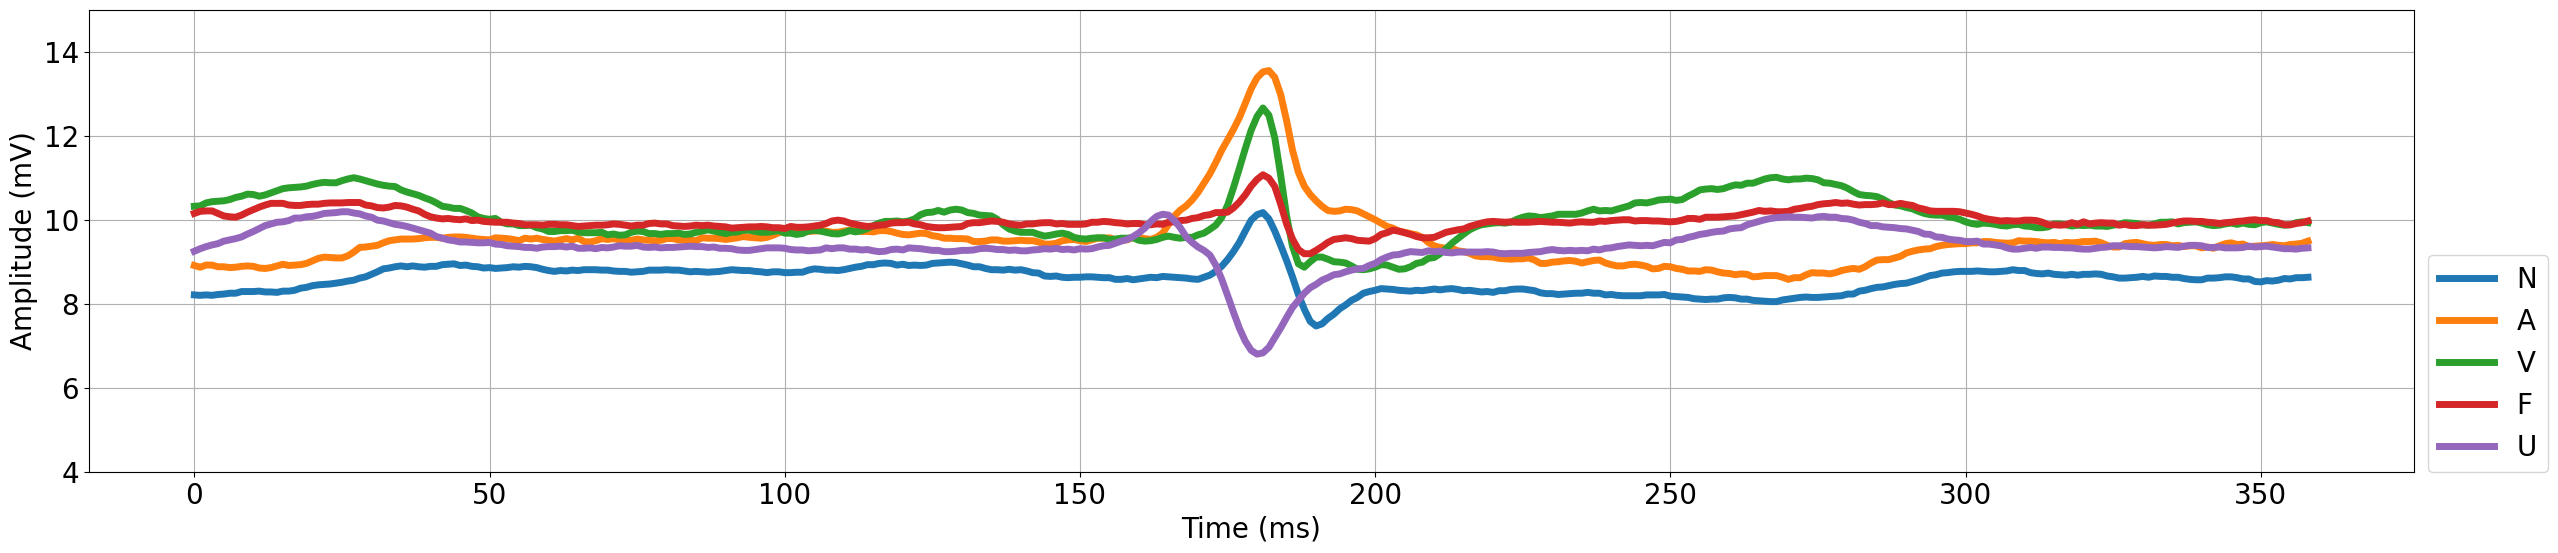

In [11]:
X_df_resam.iloc[450,0:359].plot(linewidth=5)
X_df_resam.iloc[7500,0:359].plot(linewidth=5)
X_df_resam.iloc[15000,0:359].plot(linewidth=5)
X_df_resam.iloc[21000,0:359].plot(linewidth=5)
X_df_resam.iloc[27000,0:359].plot(linewidth=5)
plt.legend(labels=['N', 'A', 'V', 'F', 'U'], bbox_to_anchor=[1, 0.5])
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (ms)')
plt.ylim(4,15)

In [12]:
X_df_resam.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
77042,7.16,7.21,7.25,7.31,7.40,7.48,7.54,7.61,7.65,7.67,...,8.10,8.14,8.18,8.19,8.21,8.21,8.21,8.21,8.21,8.19
51230,9.56,9.55,9.54,9.54,9.55,9.57,9.58,9.59,9.62,9.61,...,9.44,9.42,9.44,9.43,9.45,9.48,9.49,9.50,9.53,9.51
46415,9.81,9.80,9.81,9.83,9.87,9.86,9.85,9.80,9.82,9.85,...,9.78,9.82,9.85,9.82,9.80,9.81,9.77,9.81,9.83,9.82
25690,8.81,8.82,8.80,8.80,8.83,8.84,8.87,8.89,8.88,8.88,...,8.30,8.34,8.35,8.36,8.35,8.39,8.40,8.40,8.37,8.36
32029,8.23,8.25,8.22,8.27,8.27,8.29,8.26,8.27,8.24,8.25,...,8.23,8.24,8.26,8.27,8.24,8.25,8.25,8.19,8.19,8.24


# Machine Learning Model - Random Forest

In [13]:
#iterate over rows to calculate features by row

n_rows = np.arange(0,30000,1)
skewness = []
entropy =[]
variance = []
duplicate_max = []
abssum_changes = []
abs_energy = []
kurtosis = []
benford = []
minmax_dis_abs = []
minmax_dis = []
peak_location = []
peak_width = []
peak_time = []
upper = []
lower = []
mean_2deriv = []
rmse = []
start = time.time()
for r in n_rows:
    
    s = tf.feature_extraction.feature_calculators.skewness(X_df_resam.iloc[r,:])
    skewness.append(s)
    
    e = tf.feature_extraction.feature_calculators.sample_entropy(X_df_resam.iloc[r,:])
    entropy.append(e)
    
    v = tf.feature_extraction.feature_calculators.variance(X_df_resam.iloc[r,:])
    variance.append(v)
    
    d = tf.feature_extraction.feature_calculators.has_duplicate_max(X_df_resam.iloc[r,:])
    duplicate_max.append(d)
    
    c = tf.feature_extraction.feature_calculators.absolute_sum_of_changes(X_df_resam.iloc[r,:])
    abssum_changes.append(c)
    
    q = tf.feature_extraction.feature_calculators.abs_energy(X_df_resam.iloc[r,:])
    abs_energy.append(q) 
    
    k = tf.feature_extraction.feature_calculators.kurtosis(X_df_resam.iloc[r,:])
    kurtosis.append(k)
    
    b = tf.feature_extraction.feature_calculators.benford_correlation(X_df_resam.iloc[r,:])
    benford.append(b)
    
    msd = tf.feature_extraction.feature_calculators.mean_second_derivative_central(X_df_resam.iloc[r,:])
    mean_2deriv.append(msd)
    
    re = tf.feature_extraction.feature_calculators.root_mean_square(X_df_resam.iloc[r,:])
    rmse.append(re)
    
    m = X_df_resam.iloc[r,:]
    maxm = np.argmax(m)
    minm = np.argmin(m)
    dis_abs = abs(maxm-minm)
    minmax_dis_abs.append(dis_abs)
    
    m = X_df_resam.iloc[r,:]
    maxm = np.argmax(m)
    minm = np.argmin(m)
    dis = (maxm-minm)
    minmax_dis.append(dis)
    
    pl = (X_df_resam.iloc[r,:].sort_values(ascending=False).iloc[0])
    peak_location.append(pl)
    
    pw = (X_df_resam.iloc[r,:].sort_values(ascending=False).iloc[0]) - (X_df_resam.iloc[r,:].sort_values(ascending=False).iloc[1])
    peak_width.append(pw)
    
    pt = (X_df_resam.iloc[r,:].sort_values(ascending=False).index[0] - X_df_resam.iloc[r,:].sort_values(ascending=False).index[1])
    peak_time.append(pt)
    
    u = len(X_df_resam.iloc[r,:][X_df_resam.iloc[r,:] > ((X_df_resam.iloc[r,:].max() - X_df_resam.iloc[r,:].min())/2 + X_df_resam.iloc[r,:].min())])
    upper.append(u)
    
    l = len(X_df_resam.iloc[r,:][X_df_resam.iloc[r,:] < ((X_df_resam.iloc[r,:].max() - X_df_resam.iloc[r,:].min())/2 - X_df_resam.iloc[r,:].min())])
    lower.append(l)
    
    end = time.time()
    
    
    if (r % 10000 == 0) or (r == 0):
        print('On Row: ',r,'Time Elapsed: ',((end - start)/60),' min')

On Row:  0 Time Elapsed:  0.0005524714787801106  min
On Row:  10000 Time Elapsed:  4.202769752343496  min
On Row:  20000 Time Elapsed:  8.399456985791524  min


In [14]:
#New Features: Discrete Fourier Transform & Continuous Wavelet Transform
#this cell runs slow because of the cwt, 

start = time.time()

fft_beat = abs((X_df_resam.apply(lambda x: fft(x), axis =1)))
fft_max = []
fft_avg = []
fft_std = []

for i in range(len(fft_beat)):
    i_max = fft_beat.iloc[i].max()
    fft_max.append(i_max)
    i_avg = fft_beat.iloc[i].mean()
    fft_avg.append(i_avg)
    i_std = fft_beat.iloc[i].std()
    fft_std.append(i_std)
    end = time.time()
    
    if (i % 10000 == 0) or (i == 0):
        print('Calculating FFT     On Row: ',i,'Time Elapsed: ',((end - start)/60),' min')
    if (i == 29999):
        print('Completed FFT')
    
    
cwt_beat = []
start = time.time()
print('Starting CWT')
for i in range(len(X_df_resam)):
    i_cwt = scipy.signal.cwt(X_df_resam.iloc[i], scipy.signal.ricker, widths=np.arange(1, 361))
    cwt_beat.append(i_cwt)
cwt_max = []
cwt_avg = []
cwt_std = []

for i in range(len(cwt_beat)):
    i_max = cwt_beat[i].max()
    cwt_max.append(i_max)
    i_avg = cwt_beat[i].mean()
    cwt_avg.append(i_avg)
    i_std = cwt_beat[i].std()
    cwt_std.append(i_std)
    end = time.time()
    
    if (i % 10000 == 0) or (i == 0):
        print('Calculating CWT     On Row: ',i,'Time Elapsed: ',((end - start)/60),' min')
    if (i == 29999):
        print('Completed CWT')

Calculating FFT     On Row:  0 Time Elapsed:  0.010560234387715658  min
Calculating FFT     On Row:  10000 Time Elapsed:  0.017758349577585857  min
Calculating FFT     On Row:  20000 Time Elapsed:  0.025070567925771076  min
Completed FFT
Calculating CWT     On Row:  0 Time Elapsed:  14.576966047286987  min
Calculating CWT     On Row:  10000 Time Elapsed:  15.021546630064647  min
Calculating CWT     On Row:  20000 Time Elapsed:  15.5865727186203  min
Completed CWT


In [15]:
#create the feature table

feat_table = pd.DataFrame()

feat_table['beat_avg'] = X_df_resam.mean(axis=1)
feat_table['beat_std'] = X_df_resam.std(axis=1)
feat_table['beat_max'] = X_df_resam.max(axis=1)
feat_table['beat_min'] = X_df_resam.min(axis=1)
feat_table['beat_range'] = feat_table['beat_max'] - feat_table['beat_min']
feat_table['beat_ratio'] = feat_table['beat_min']/feat_table['beat_max']

#features by each quarter of beat
feat_table['qtr1_avg'] = X_df_resam.iloc[:,0:90].mean(axis=1)
feat_table['qtr1_std'] = X_df_resam.iloc[:,0:90].std(axis=1)
feat_table['qtr1_max'] = X_df_resam.iloc[:,0:90].max(axis=1)
feat_table['qtr1_min'] = X_df_resam.iloc[:,0:90].min(axis=1)
feat_table['qtr1_var'] = X_df_resam.iloc[:,0:90].var(axis=1)

feat_table['qtr2_avg'] = X_df_resam.iloc[:,91:179].mean(axis=1)
feat_table['qtr2_std'] = X_df_resam.iloc[:,91:179].std(axis=1)
feat_table['qtr2_max'] = X_df_resam.iloc[:,91:179].max(axis=1)
feat_table['qtr2_min'] = X_df_resam.iloc[:,91:179].min(axis=1)
feat_table['qtr2_var'] = X_df_resam.iloc[:,91:179].var(axis=1)

feat_table['qtr3_avg'] = X_df_resam.iloc[:,180:269].mean(axis=1)
feat_table['qtr3_std'] = X_df_resam.iloc[:,180:269].std(axis=1)
feat_table['qtr3_max'] = X_df_resam.iloc[:,180:269].max(axis=1)
feat_table['qtr3_min'] = X_df_resam.iloc[:,180:269].min(axis=1)
feat_table['qtr3_var'] = X_df_resam.iloc[:,180:269].var(axis=1)

feat_table['qtr4_avg'] = X_df_resam.iloc[:,270:359].mean(axis=1)
feat_table['qtr4_std'] = X_df_resam.iloc[:,270:359].std(axis=1)
feat_table['qtr4_max'] = X_df_resam.iloc[:,270:359].max(axis=1)
feat_table['qtr4_min'] = X_df_resam.iloc[:,270:359].min(axis=1)
feat_table['qtr4_var'] = X_df_resam.iloc[:,270:359].var(axis=1)

#ts fresh features
feat_table['skewness'] = skewness
feat_table['entropy'] = entropy
feat_table['variance'] = variance
feat_table['duplicate_max'] = duplicate_max
feat_table['abssum_changes'] = abssum_changes
feat_table['abs_energy'] = abs_energy
feat_table['mean_2deriv'] = mean_2deriv
feat_table['rmse'] = rmse

#morphological features
feat_table['minmax_dis_abs'] = minmax_dis_abs
feat_table['minmax_dis'] = minmax_dis
feat_table['peak_location'] = peak_location
feat_table['peak_width'] = peak_width
feat_table['peak_time'] = peak_time
feat_table['upper'] = upper
feat_table['lower'] = lower

#signal transformation features (dft & cwt)
feat_table['fft_max'] = fft_max
feat_table['fft_avg'] = fft_avg
feat_table['fft_std'] = fft_std

feat_table['cwt_max'] = cwt_max
feat_table['cwt_avg'] = cwt_avg
feat_table['cwt_std'] = cwt_std


feat_table.dropna(inplace=True)
feat_table

,beat_avg,beat_std,beat_max,beat_min,beat_range,beat_ratio,qtr1_avg,qtr1_std,qtr1_max,qtr1_min,...,peak_width,peak_time,upper,lower,fft_max,fft_avg,fft_std,cwt_max,cwt_avg,cwt_std
77042,8.006611,0.858765,12.99,6.73,6.26,0.518091,7.963889,0.221855,8.16,7.16,...,0.07,1,12,0,2882.38,14.335278,152.109665,122.604495,70.241969,37.134427
51230,9.589167,0.289157,11.83,9.26,2.57,0.782756,9.618000,0.080618,9.79,9.47,...,0.09,-1,8,0,3452.10,12.052346,181.624667,146.239120,83.933702,44.072446
46415,9.905750,0.348433,12.01,9.62,2.39,0.800999,9.778333,0.039184,9.89,9.70,...,0.03,-1,12,0,3566.07,12.354810,187.658043,151.283028,86.780759,45.637853
25690,8.788028,0.578751,12.95,6.66,6.29,0.514286,8.861333,0.234938,9.24,8.53,...,0.21,-1,9,0,3163.69,13.940668,166.518772,134.015762,76.929982,40.385443
32029,8.408000,0.656865,12.36,7.74,4.62,0.626214,8.194556,0.061061,8.30,8.08,...,0.02,1,10,0,3026.88,13.452277,159.448868,128.514665,73.706750,38.797909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,10.332472,0.953260,13.37,7.52,5.85,0.562453,10.247778,0.608785,11.39,9.63,...,0.23,1,135,0,3719.69,18.321376,196.020780,156.598173,90.098422,47.113869
79996,9.639944,0.709982,12.01,8.44,3.57,0.702748,9.680444,0.179481,10.04,9.45,...,0.01,-1,41,0,3470.38,12.877459,182.946452,147.621131,84.575351,44.708603
11094,10.019306,1.507573,13.11,5.97,7.14,0.455378,11.257778,1.591189,13.11,7.63,...,0.03,1,249,0,3606.95,17.601822,191.429456,151.459652,87.343244,45.626238
10269,10.066222,1.128477,14.86,8.39,6.47,0.564603,10.213889,0.766377,14.04,9.10,...,0.03,1,23,0,3623.84,19.826044,191.160872,153.803836,88.186574,46.623827


In [50]:
feat_table.var().sort_values(ascending=True)

mean_2deriv       3.737656e-08
peak_width        2.941849e-03
entropy           9.510135e-03
beat_ratio        1.292006e-02
qtr4_std          6.699628e-02
duplicate_max     8.646352e-02
qtr2_std          1.033017e-01
beat_std          1.159270e-01
qtr1_std          1.275509e-01
qtr4_var          1.590581e-01
qtr3_std          2.376928e-01
qtr1_var          2.708165e-01
qtr2_var          2.727546e-01
qtr2_avg          3.163749e-01
rmse              3.499360e-01
beat_avg          3.582664e-01
qtr1_avg          4.190069e-01
variance          4.883495e-01
qtr3_avg          4.910319e-01
qtr4_avg          5.199203e-01
qtr1_min          5.672375e-01
qtr4_min          8.345412e-01
qtr2_min          9.456498e-01
qtr4_max          1.056337e+00
qtr3_min          1.328258e+00
beat_min          1.366885e+00
beat_max          1.464388e+00
peak_location     1.464388e+00
qtr3_max          1.518049e+00
qtr2_max          1.620630e+00
qtr3_var          1.676404e+00
qtr1_max          1.769020e+00
beat_ran

In [17]:
#select the relevant features with a variance above the threshold
selector = VarianceThreshold(threshold=0.25)
selector.fit(feat_table)
X_V = feat_table.columns[selector.get_support()]
print('Selected Features = ', X_V.to_list())
print(' ')
print('Discarded Features = ',[x for x in feat_table.columns if x not in X_V.to_list()])

Selected Features =  ['beat_avg', 'beat_max', 'beat_min', 'beat_range', 'qtr1_avg', 'qtr1_max', 'qtr1_min', 'qtr1_var', 'qtr2_avg', 'qtr2_max', 'qtr2_min', 'qtr2_var', 'qtr3_avg', 'qtr3_max', 'qtr3_min', 'qtr3_var', 'qtr4_avg', 'qtr4_max', 'qtr4_min', 'skewness', 'variance', 'abssum_changes', 'abs_energy', 'rmse', 'minmax_dis_abs', 'minmax_dis', 'peak_location', 'peak_time', 'upper', 'lower', 'fft_max', 'fft_avg', 'fft_std', 'cwt_max', 'cwt_avg', 'cwt_std']
 
Discarded Features =  ['beat_std', 'beat_ratio', 'qtr1_std', 'qtr2_std', 'qtr3_std', 'qtr4_std', 'qtr4_var', 'entropy', 'duplicate_max', 'mean_2deriv', 'peak_width']


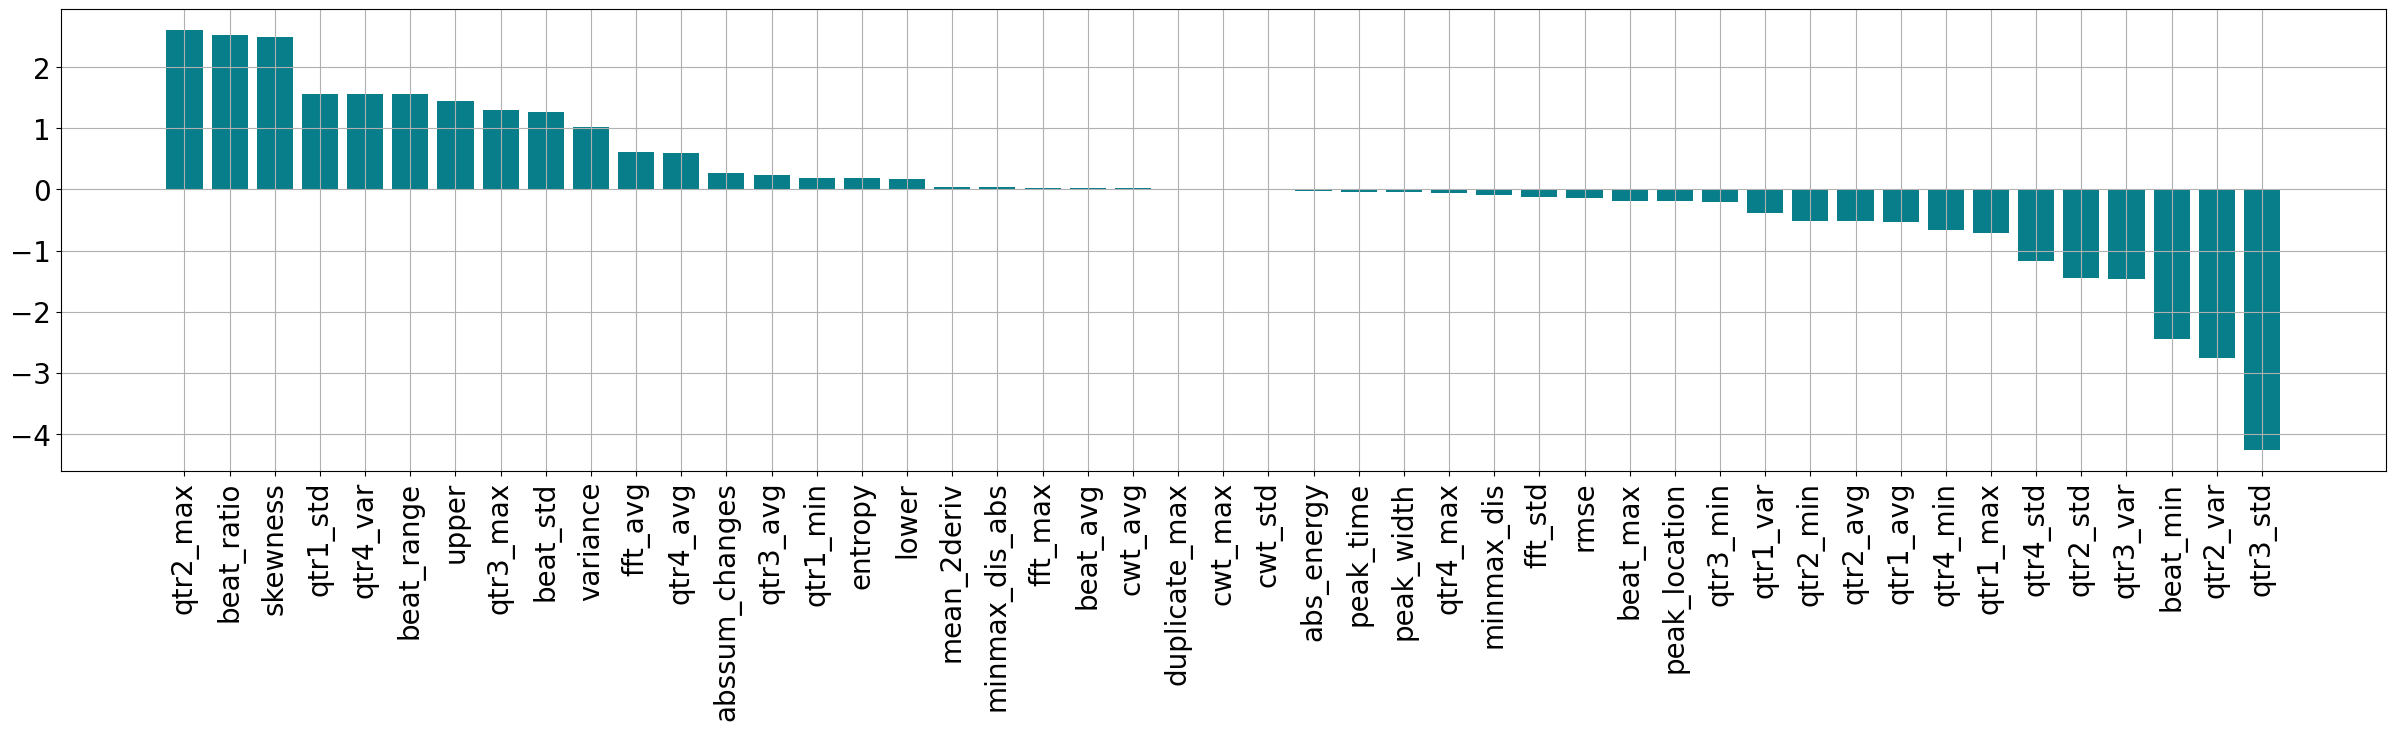

In [63]:
#Ranking Features
X_train, X_test, y_train, y_test = train_test_split(feat_table,category,test_size=0.4,stratify = category)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
#plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.savefig('feat_import.svg', bbox_inches='tight')
plt.show()


In [64]:
#splitting the data into testing and training
#have to specify the paramter 'stratify' to make sure the categories are evenly split
X_train, X_test, y_train, y_test = train_test_split(feat_table[X_V],category,test_size=0.4,stratify = category)

In [65]:
#use random forest classifying
start = time.time()
from sklearn.ensemble import RandomForestClassifier
RndFst = RandomForestClassifier()
RndFst.fit(X_train,y_train)
rf_predictions = RndFst.predict(X_test)
rf_predictions.shape
end = time.time()
print('The model ran in ',(abs(start-end)),' s')

The model ran in  6.432890176773071  s


              precision    recall  f1-score   support

           0   0.957012  0.955417  0.956214      2400
           1   0.982902  0.982083  0.982493      2400
           2   0.989548  0.986250  0.987896      2400
           3   0.977055  0.975833  0.976444      2400
           4   0.973521  0.980417  0.976957      2400

    accuracy                       0.976000     12000
   macro avg   0.976008  0.976000  0.976001     12000
weighted avg   0.976008  0.976000  0.976001     12000



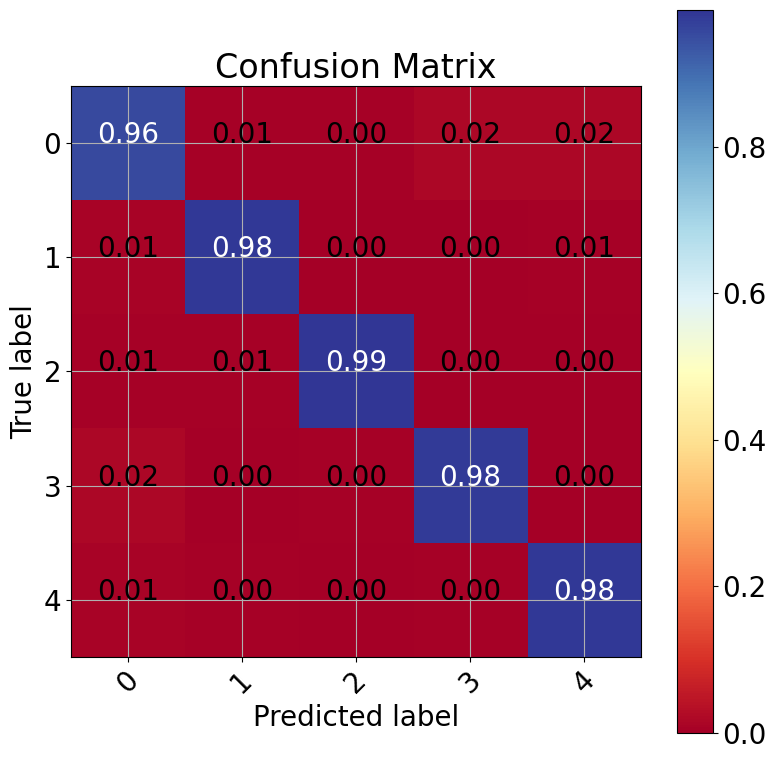

In [68]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_predictions)
np.set_printoptions(precision=2)

print(classification_report(y_test, rf_predictions, digits=6))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4'],
                      title='Confusion Matrix')
plt.savefig('rfcm.svg')
plt.show()

# Deep Learning Model #1 - Multi-Layer Perceptron

In [22]:
#split data into testing, training, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)
na, X_val, na, y_val = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)

In [23]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)

In [24]:
print( "X_train Shape: ",X_train.shape, "X_test Shape: ",X_test.shape, "y_train Shape: ",y_train.shape, "y_test Shape: ",y_test.shape)

X_train Shape:  (21000, 360) X_test Shape:  (9000, 360) y_train Shape:  (21000, 5) y_test Shape:  (9000, 5)


In [26]:
mlp_model = Sequential()
mlp_model.add(Dense(360, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dense(182, activation='relu'))
mlp_model.add(Dense(182, activation='relu'))
mlp_model.add(Dense(5, activation='softmax'))

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 360)               129960    
                                                                 
 dense_6 (Dense)             (None, 182)               65702     
                                                                 
 dense_7 (Dense)             (None, 182)               33306     
                                                                 
 dense_8 (Dense)             (None, 5)                 915       
                                                                 
Total params: 229,883
Trainable params: 229,883
Non-trainable params: 0
_________________________________________________________________


In [27]:
mlp_model_history = mlp_model.fit(X_train, y_train ,validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
657/657 [==============================] - 2s 2ms/step - loss: 1.4829 - accuracy: 0.4017 - val_loss: 0.9768 - val_accuracy: 0.6872
Epoch 2/15
657/657 [==============================] - 1s 2ms/step - loss: 0.8806 - accuracy: 0.6589 - val_loss: 0.7809 - val_accuracy: 0.6787
Epoch 3/15
657/657 [==============================] - 1s 2ms/step - loss: 0.7341 - accuracy: 0.7255 - val_loss: 1.2100 - val_accuracy: 0.6256
Epoch 4/15
657/657 [==============================] - 1s 2ms/step - loss: 0.6100 - accuracy: 0.7775 - val_loss: 0.5104 - val_accuracy: 0.8148
Epoch 5/15
657/657 [==============================] - 1s 2ms/step - loss: 0.5496 - accuracy: 0.7997 - val_loss: 1.0705 - val_accuracy: 0.5853
Epoch 6/15
657/657 [==============================] - 1s 2ms/step - loss: 0.4734 - accuracy: 0.8285 - val_loss: 0.3364 - val_accuracy: 0.8762
Epoch 7/15
657/657 [==============================] - 1s 2ms/step - loss: 0.4468 - accuracy: 0.8373 - val_loss: 0.3432 - val_accuracy: 0.8702
Epoch 

Accuracy: 92.02%


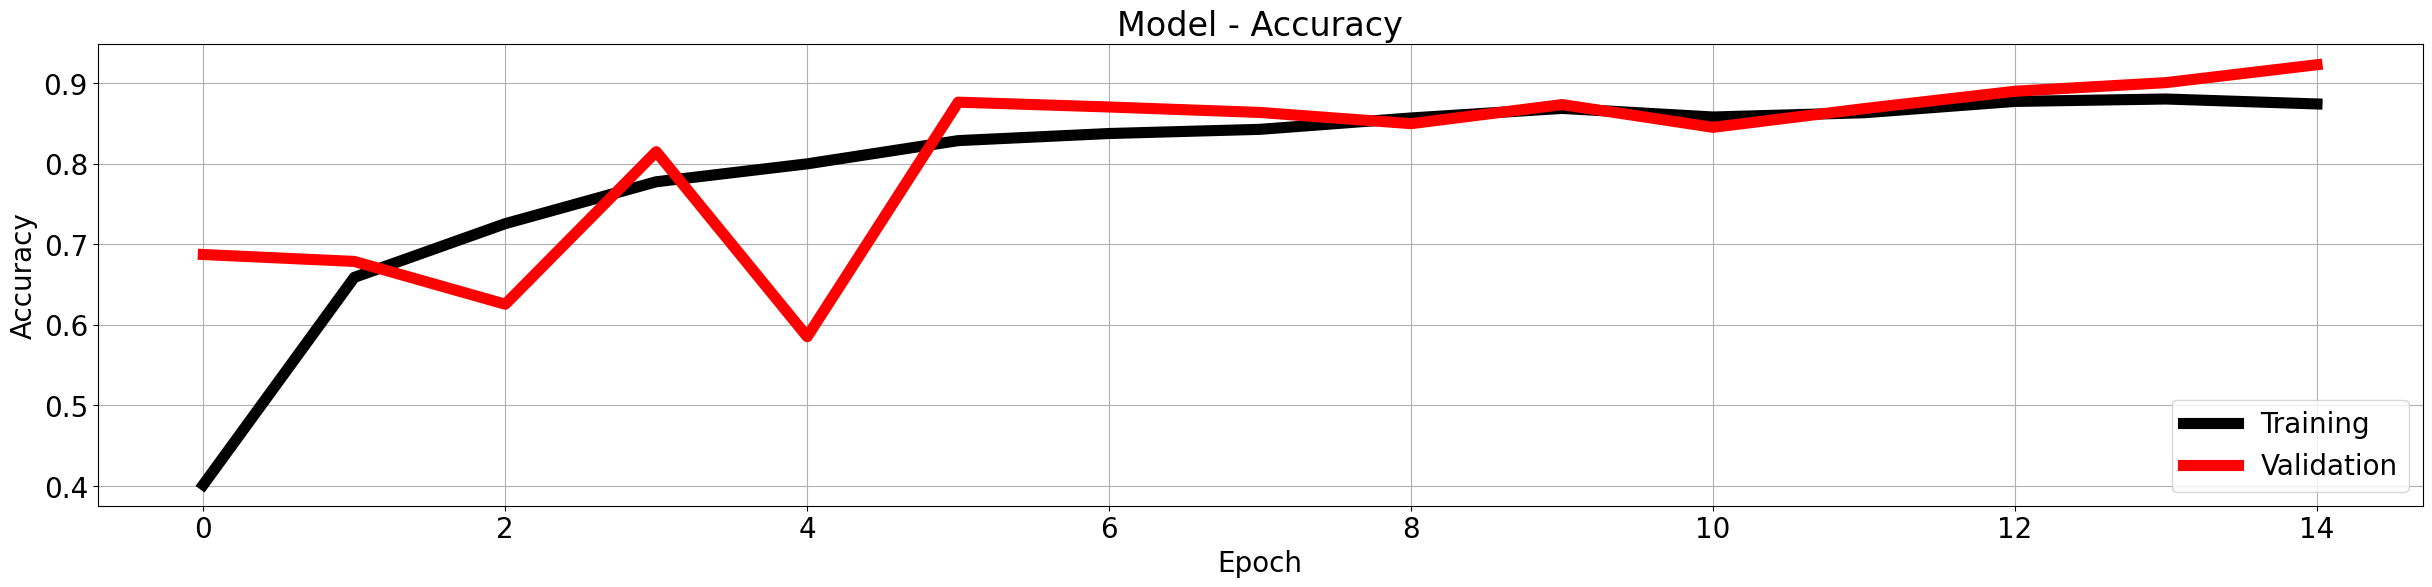

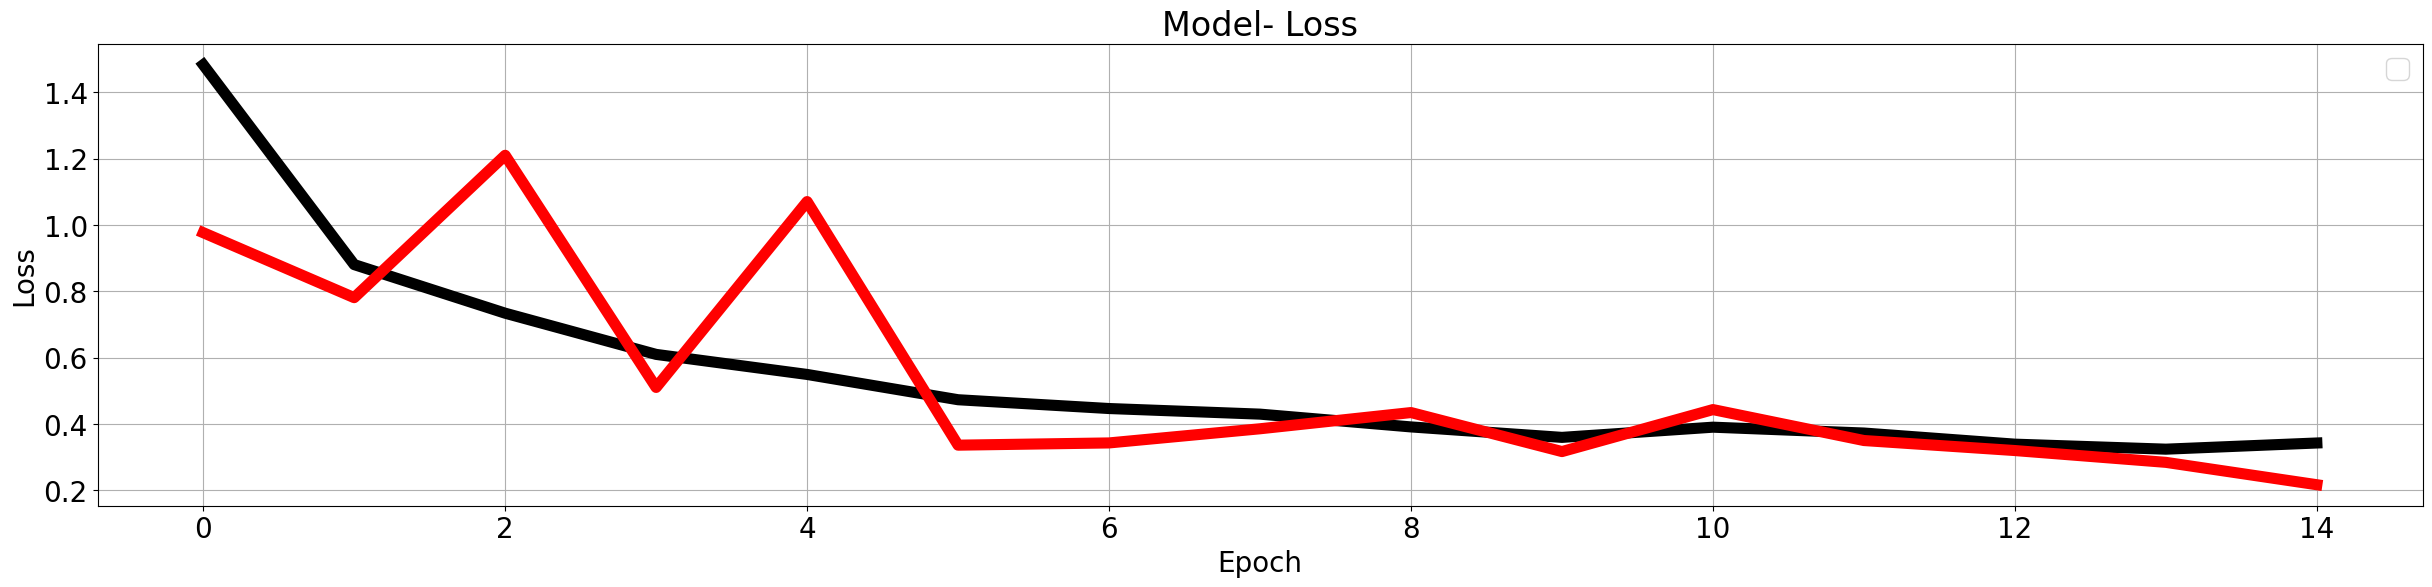

282/282 [==============================] - 0s 773us/step


In [28]:
evaluate_model(mlp_model_history,X_val,y_val,mlp_model)
y_pred=mlp_model.predict(X_val)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1800
           1       0.98      0.98      0.98      1800
           2       0.98      0.92      0.95      1800
           3       0.83      0.89      0.85      1800
           4       0.95      0.97      0.96      1800

    accuracy                           0.92      9000
   macro avg       0.92      0.92      0.92      9000
weighted avg       0.92      0.92      0.92      9000



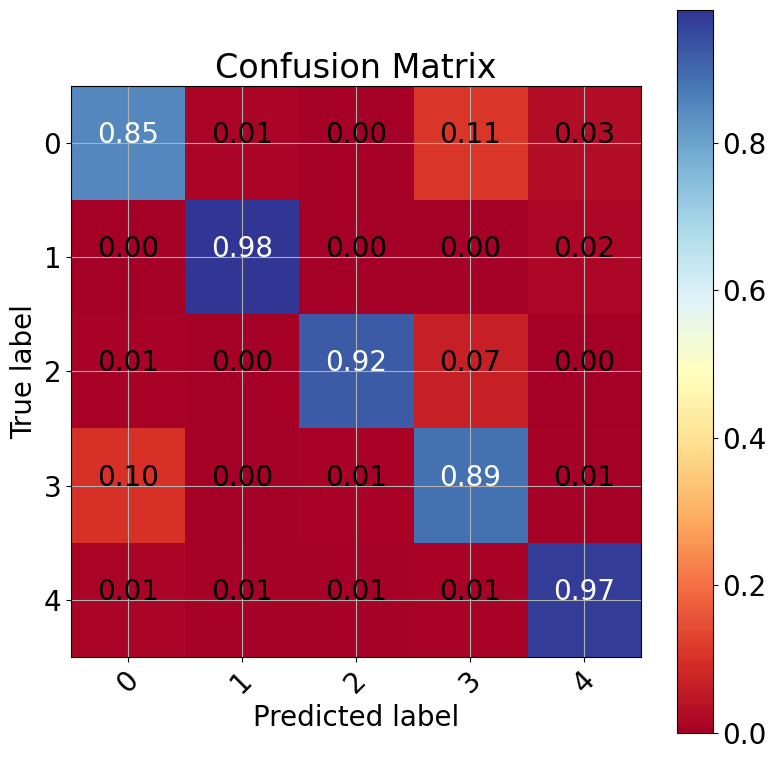

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
# 
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4'],
                      title='Confusion Matrix')
plt.show()

# Deep Learning Model #2 - Convolutional Neural Network

In [30]:
#split data into testing & training

X_train, X_test, y_train, y_test = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)
na, X_val, na, y_val = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)

In [31]:
#check that testing and validation are different
if X_test.equals(X_val)==True:
    print("The testing and validation sets are identical, perform splitting again")
else: 
    print("The testing and validation sets are not identical")

The testing and validation sets are not identical


In [32]:
#histogram 

In [33]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val = to_categorical(y_val)

In [34]:
print( "X_train Shape: ",X_train.shape, "X_test Shape: ",X_test.shape, "y_train Shape: ",y_train.shape, "y_test Shape: ",y_test.shape)

X_train Shape:  (21000, 360) X_test Shape:  (9000, 360) y_train Shape:  (21000, 5) y_test Shape:  (9000, 5)


In [35]:

cnn_model = Sequential()

# Filters = Units in Dense Total number of Neurons
cnn_model.add(Convolution1D(filters = 64, kernel_size = 6, activation='relu', padding = 'same', input_shape = (X_train.shape[1], 1))) 
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

cnn_model.add(Convolution1D(filters = 64, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

cnn_model.add(Convolution1D( filters = 64, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

# Flatten 
cnn_model.add(Flatten())

# Fully connected layer
# input layer
cnn_model.add(Dense(units = 64, activation='relu'))

# Hidden Layer
cnn_model.add(Dense(units = 64, activation='relu'))

# Output Layer
cnn_model.add(Dense(units = 5, activation='softmax'))

# loss = 'categorical_crossentropy'
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 360, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 180, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 180, 64)           24640     
                                                                 
 batch_normalization_1 (Batc  (None, 180, 64)          256       
 hNormalization)                                                 
                                                      

In [36]:
#trainable params are weight on nn based on data
#more trainable params mean more complex nn
#lower params -> lower cost 

In [37]:
#try epochs > 100
history = cnn_model.fit(X_train, y_train, epochs = 25, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/25
657/657 [==============================] - 12s 18ms/step - loss: 0.2426 - accuracy: 0.9174 - val_loss: 0.5565 - val_accuracy: 0.8774
Epoch 2/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0955 - accuracy: 0.9680 - val_loss: 3.1021 - val_accuracy: 0.3102
Epoch 3/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0691 - accuracy: 0.9783 - val_loss: 1.1609 - val_accuracy: 0.6939
Epoch 4/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0473 - accuracy: 0.9841 - val_loss: 2.8120 - val_accuracy: 0.5698
Epoch 5/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0465 - accuracy: 0.9859 - val_loss: 0.8625 - val_accuracy: 0.7490
Epoch 6/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.4587 - val_accuracy: 0.8500
Epoch 7/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0301 - accuracy: 0.9910 - val_loss: 1.4324 - val_accuracy:

In [38]:
cnn_model.evaluate(X_test, y_test)

282/282 [==============================] - 2s 5ms/step - loss: 0.1830 - accuracy: 0.9554


[0.1830161064863205, 0.9554444551467896]

In [39]:
cnn_model.evaluate(X_val, y_val)

282/282 [==============================] - 2s 5ms/step - loss: 0.1529 - accuracy: 0.9612


[0.15288160741329193, 0.961222231388092]

Accuracy: 95.54%


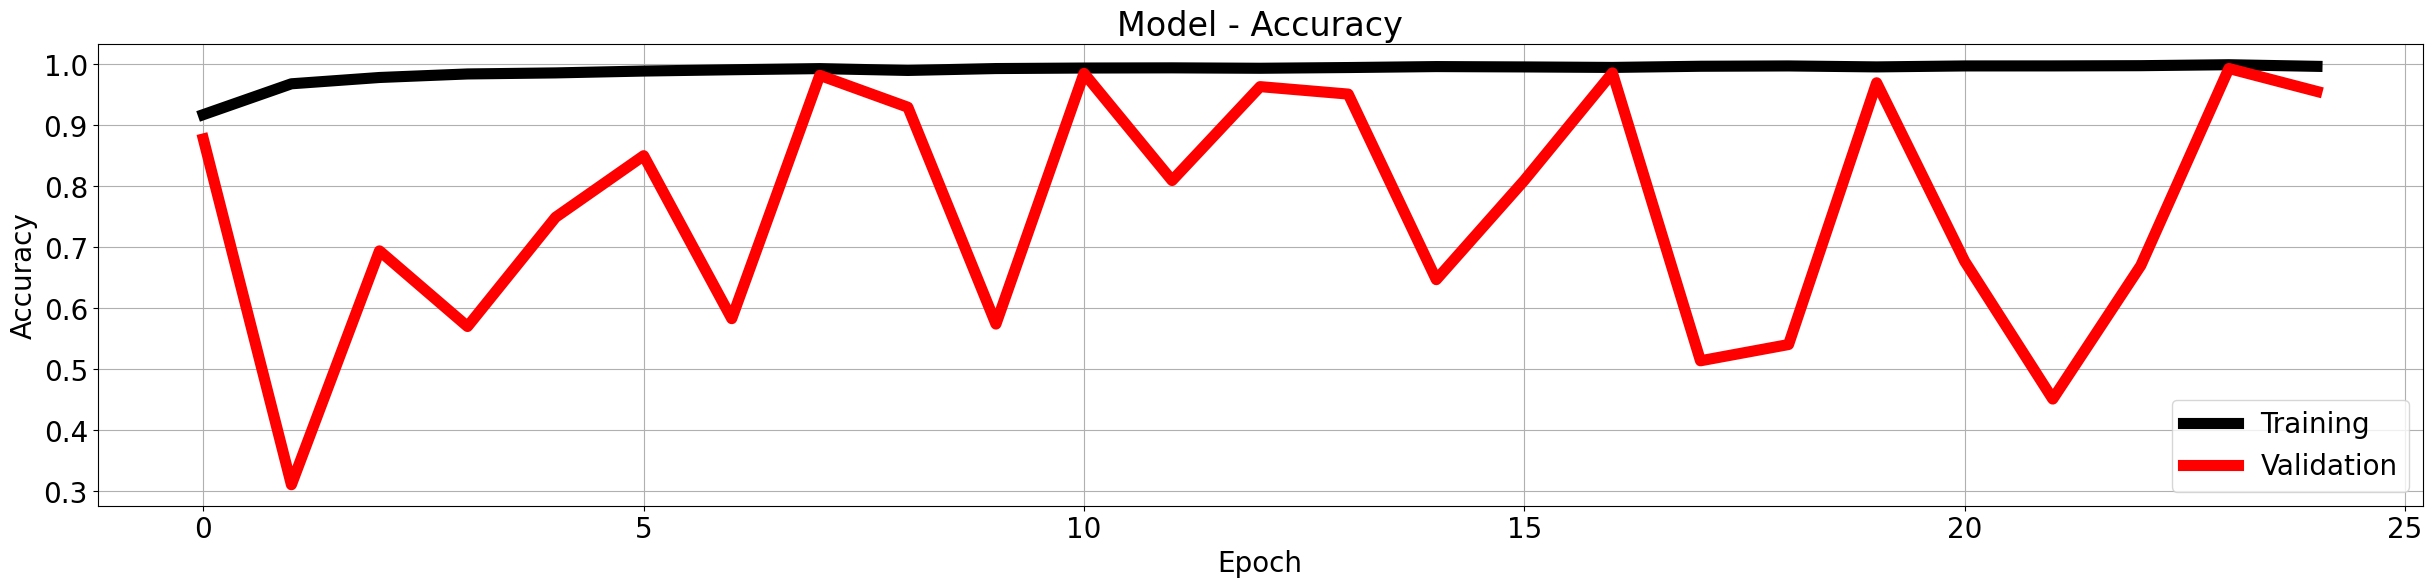

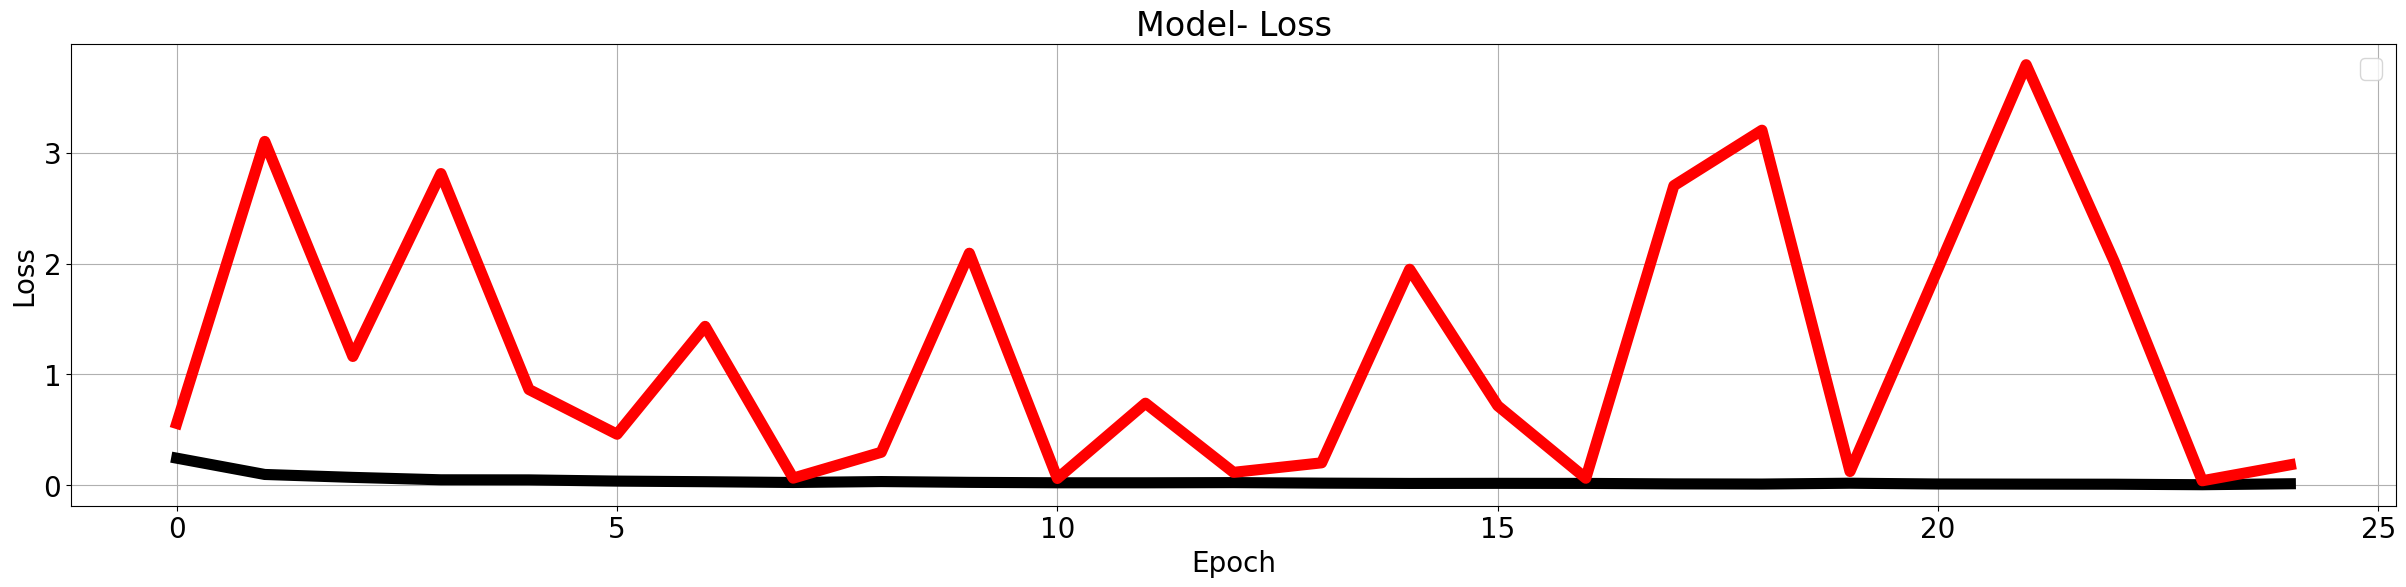

282/282 [==============================] - 2s 5ms/step


In [40]:
evaluate_model(history,X_test,y_test,cnn_model)
y_pred=cnn_model.predict(X_val)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1800
           1       0.99      0.99      0.99      1800
           2       0.99      0.95      0.97      1800
           3       0.92      0.94      0.93      1800
           4       0.96      0.99      0.97      1800

    accuracy                           0.96      9000
   macro avg       0.96      0.96      0.96      9000
weighted avg       0.96      0.96      0.96      9000



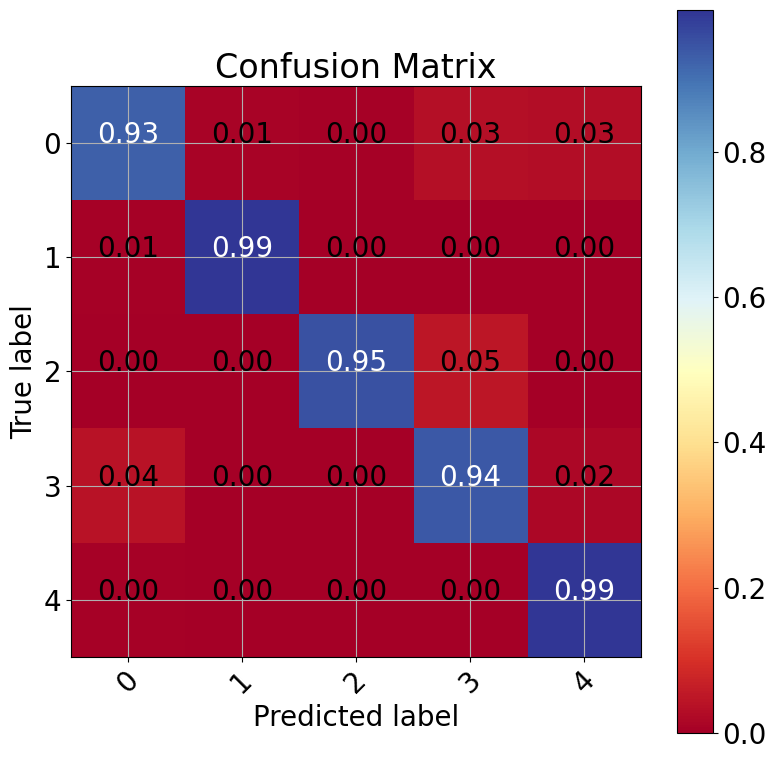

In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=4)

print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4'],
                      title='Confusion Matrix')
plt.show()

# One Class Classification - Work in Progress

In [ ]:
#test isolation forest with one abnormal class added at a time
#oneclassSVM with one class at a time

##### Work in progress, runs (technically) but doesn't produce very good results.
##### Getting outputs all the same. Inputting all normal beats for training and testing on data with mostly normal beats & some others but the output I get is all other (-1), even for the normal beats which should be 1. Tried inputting beats without features, tried using the feature table, tried scaling, tried Isolation forest & oneclassSVM, not sure what is missing & where it is incorrect

### Testing OneClassSVM

In [153]:
X_df = pd.DataFrame(X)
#taking normal and class 1 (atrial abnormal)
X_df_oc = X_df.loc[(X_df[360]== 0) | (X_df[360]== 1)]

In [107]:
X_df_oc[360] = (np.where(X_df_oc[360] == 0, 1, -1))
print("There are ",np.unique(X_df_oc[360], return_counts=True)[1][1]," samples of Normal Beats")
print("There are ",np.unique(X_df_oc[360], return_counts=True)[1][0]," samples of Abnormal Beats")

There are  75011  samples of Normal Beats
There are  8071  samples of Abnormal Beats


/var/folders/9p/hzj7ch392lg17l9_qd41j1j00000gn/T/ipykernel_86948/3016401019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_df_oc[360] = (np.where(X_df_oc[360] == 0, 1, -1))


In [154]:
#creating a training dataset of only normal beats
X_train = X_df_oc.loc[X_df_oc[360]==0].sample(58000)

In [165]:
#creating a testing set 
na, X_test, na, y_test = train_test_split(X_df_oc.iloc[:,0:360],X_df_oc[360],test_size=0.3,stratify = X_df_oc[360])

In [167]:
#this line turns all of the 0 (normal) to 1 and all 1 (abnormal) to -1
y_test = np.where(y_test==0, 1,-1)
np.unique(y_test, return_counts=True)

In [74]:
# normalize the data
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(class0)
# class0_scaled = scaler.transform(class0)
# scaler.fit(X_test)
# X_test_scaled = scaler.transform(X_test)

In [141]:
#run model
one_class = svm.OneClassSVM(gamma='auto', kernel='rbf', nu=0.5)
one_class.fit(X_train.iloc[:,0:360])
one_class_pred = one_class.predict(X_test)

              precision    recall  f1-score   support

          -1       0.10      0.99      0.18       298
           1       0.81      0.01      0.01      2702

    accuracy                           0.10      3000
   macro avg       0.45      0.50      0.10      3000
weighted avg       0.74      0.10      0.03      3000



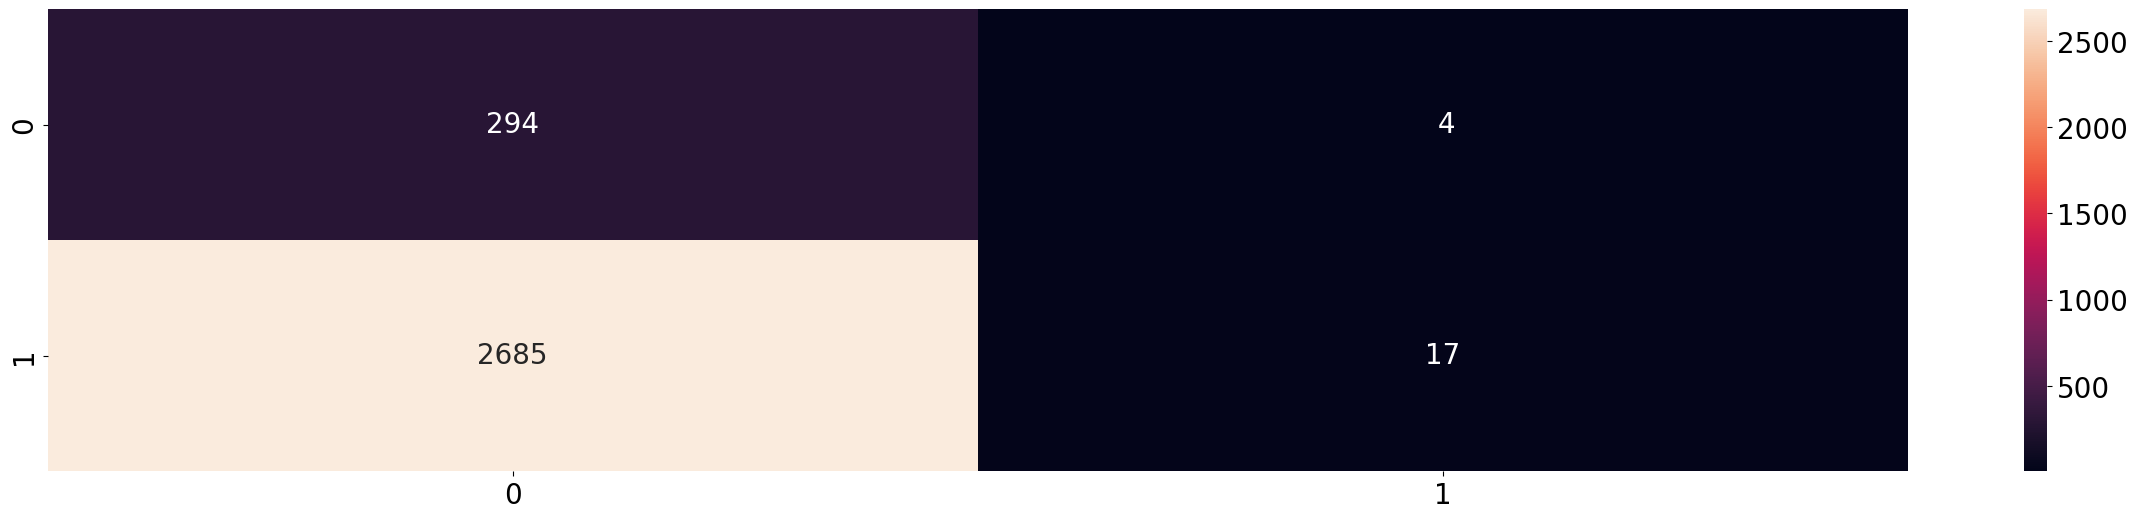

In [119]:
print(classification_report(y_test, one_class_pred))
sns.heatmap(confusion_matrix(y_test, one_class_pred),annot=True,fmt='2.0f')
plt.show()

### Testing IsolationForest

In [169]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(X_train.iloc[:,0:360])
y_pred = clf.predict(X_test)


              precision    recall  f1-score   support

          -1       0.09      0.07      0.08      2421
           1       0.90      0.92      0.91     22504

    accuracy                           0.84     24925
   macro avg       0.50      0.50      0.50     24925
weighted avg       0.82      0.84      0.83     24925



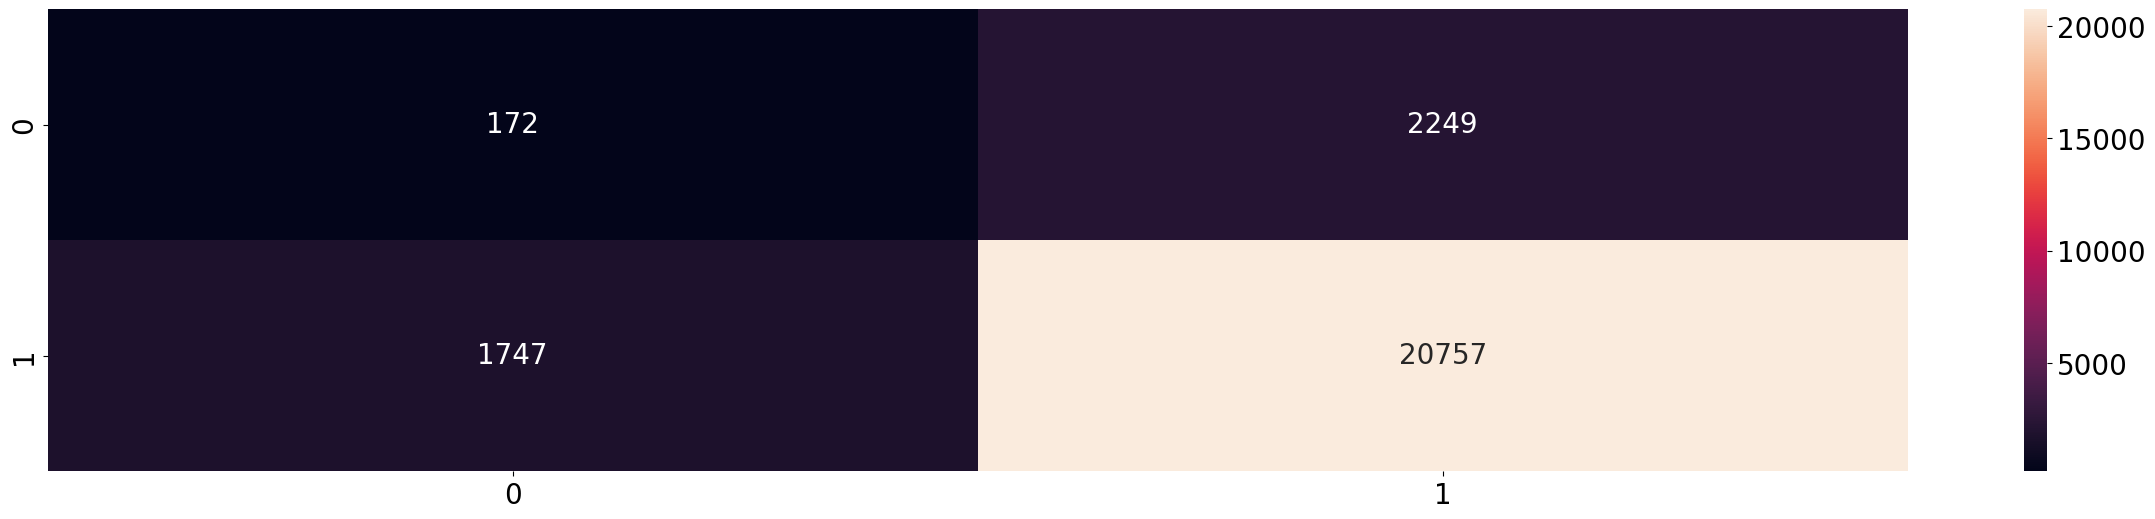

In [170]:
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='2.0f')
plt.show()